인간은 의사결정 이유를 설명하는 능력이 뛰어남
  - 뛰어난 성능 제공하지만 설명 기능이 약한 결정적 한계, 블백박스라는 비난
  - 1980년대 규칙기반 방법이나 결정트리 설명기능이 강화( 성능 낮다)
  - DARPA는 2017년 설명가능 인공지능(XAI,explaining AI) 프로젝트 시작
  - 2016년 유럽연합에서 GDPR에 설명 받을 권리를 명시함

유방암 데이터


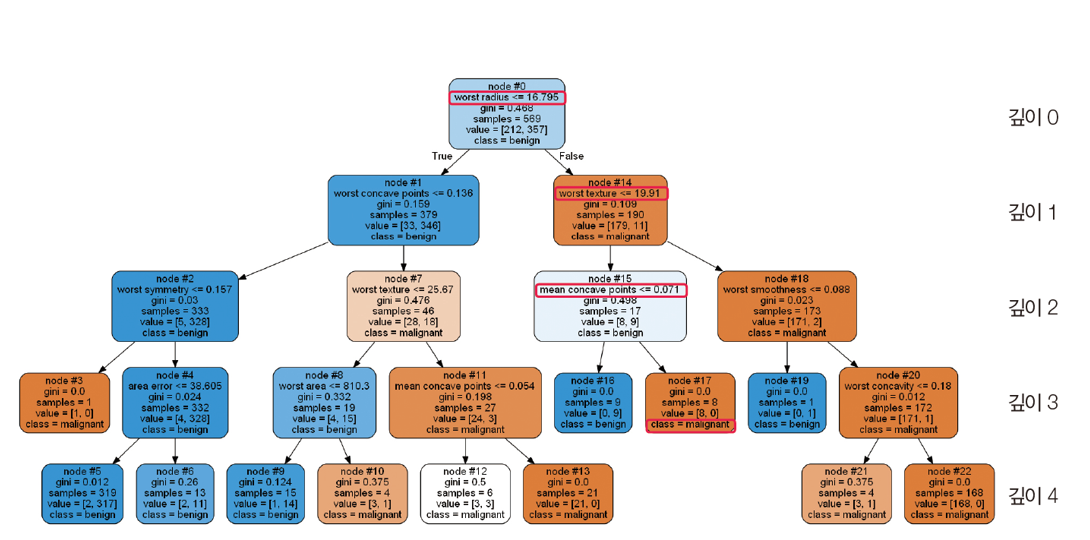

In [1]:
# 23개의 노드(  단말노드(잎노드)-->종단지점 ,나머지는 비 단말 노드)
# 유방암 데이터 : 569개의 환자 샘플로 구성, 30개 특징, 레이블 begin(양성), malignant(악성) 인 이진 분류

In [2]:
# 비 단말 노드에는 질문이 있음
# 훈련집합을 가지고 질문을 만드는... 특징과 임계값을정하고 , 동질성을 잘 확보하도록 부분집합 2개로 나누는 과정
# 동질성은 같은 부류의 샘플이 같은 자식노드로 이동--> 지니계수로 측정

In [7]:
# 유방암 데이터의 내용을 확인
from sklearn.datasets import load_breast_cancer
wdbc = load_breast_cancer()
print(f"특징 이름 : {list(wdbc.feature_names)}")
print(f"부류 이름 : {list(wdbc.target_names)}")

특징 이름 : ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
부류 이름 : ['malignant', 'benign']


In [14]:
from sklearn import tree
import pydotplus  # 결정트리를 그리는데 씀

decision_tree =  tree.DecisionTreeClassifier(max_depth=4,random_state=1)  # 동질성이 확보되지 않더라고 멈춤
decision_tree.fit(wdbc.data,wdbc.target) # 트리 학습

res = decision_tree.predict(wdbc.data)
res.shape, wdbc.target.shape
decision_tree.score(wdbc.data,wdbc.target),  sum(res == wdbc.target) / len(res)

(0.9824253075571178, 0.9824253075571178)

In [15]:
dot = tree.export_graphviz(decision_tree,out_file=None, feature_names = wdbc.feature_names,
                           class_names=wdbc.target_names, filled=True, node_ids=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot)

In [16]:
graph.write_png('tree.png')  # 결정트리 그림 저장

True

In [19]:
# 0번 샘플을 테스트 샘플로
x_test = wdbc.data[:1]
path = decision_tree.decision_path(x_test)
path_seq = path.toarray()[0]
path_seq

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0])

In [20]:
for n, value in enumerate(path_seq):
  node = graph.get_node(str(n))[0]
  if value == 0:
    node.set_fillcolor('white')
  else:
    node.set_fillcolor('green')
graph.write_png('tree_width_path.png')

True

In [21]:
decision_tree.predict(x_test)

array([0])

In [22]:
# GradCAM   이미지와 같은 영상을 인공지이 판별할때 시각화 수준으로 제공
# 전역평균 폴링

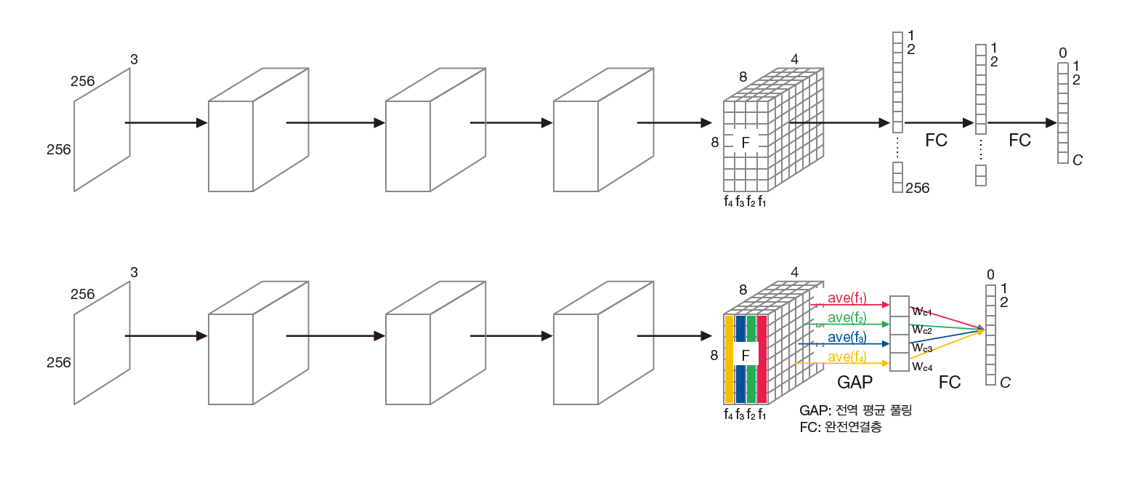

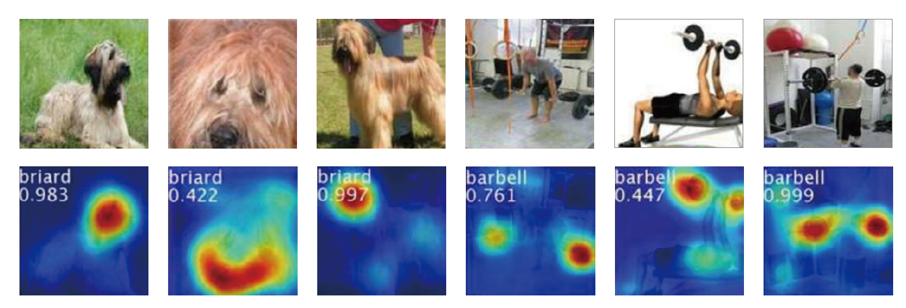

CAM은 혁신적인 아이디어
  - 단점은 전역평균폴리에 의존... 전역평균 폴링을 사용하지 않는 모델에서는 불가능

GradCAM은 CAM의 확장
  - 전역평균 폴링을 사용하지 않는 모델에 적용

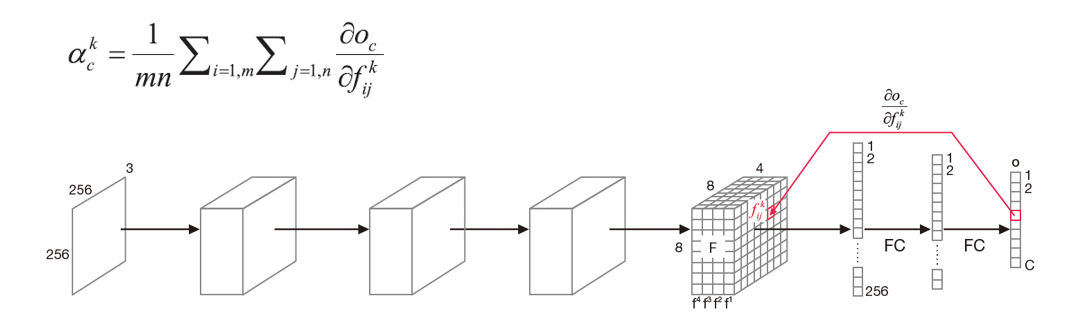

In [23]:
# K번째 특징 맵의 그레이디언트에 전역 평균 폴링을 적용

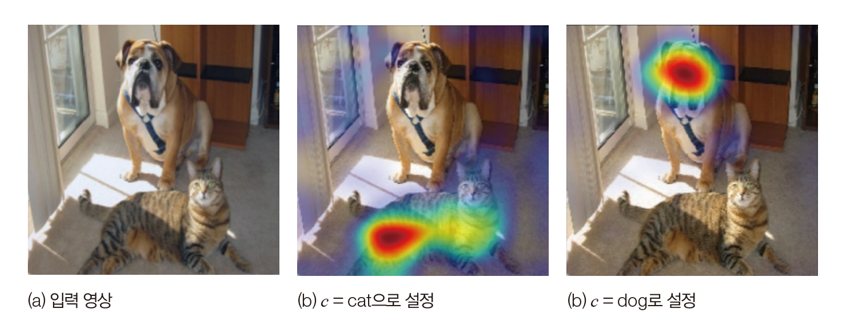

사전학습된 컨볼류션 신경망에 GradeCAM을 적용

In [26]:
# 1. RedNet50
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

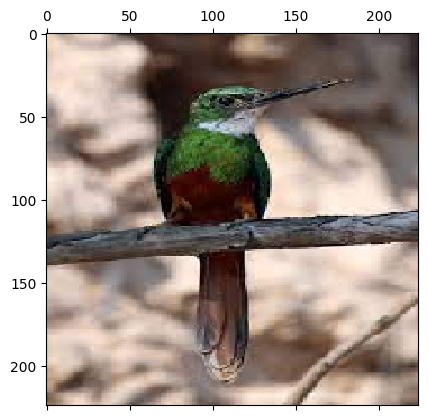

In [45]:
# 사전학습(전이학습) 모델 로드하고 신경망 구조 확인
model = ResNet50(weights='imagenet')
# model.summary()   # input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []
image_path = '/content/jacamar.jpg'
img = image.load_img(image_path,target_size=(224,224))
plt.matshow(img)

In [46]:
# 영상을 신경망에 입력 형태로 변환
x = image.img_to_array(img)  # (224,224,3))
x = np.expand_dims(x,axis=0) # (1,224,224,3)
x = resnet50.preprocess_input(x)  # 학습이 잘 되게 전이학습에 맞는 형태로 변환
preds = model.predict(x)
print(f"예측결과 : {resnet50.decode_predictions(preds,top=5)[0]}")

1/1 [==============================] - 1s 1s/step
예측결과 : [('n01843065', 'jacamar', 0.9914078), ('n01833805', 'hummingbird', 0.005232674), ('n01828970', 'bee_eater', 0.002792924), ('n01601694', 'water_ouzel', 6.6269626e-05), ('n04604644', 'worm_fence', 4.2320393e-05)]


In [47]:
print([lname.name for lname in model.layers[-3:]])

last_conv_layer = model.get_layer('conv5_block3_out')
# 특징추출 부분만으로 구성된 모델
model_1 = keras.Model(model.inputs, last_conv_layer.output)
# 분류(전역폴링 또는 완전연결층) 부분만 구성된 모델
input_2 = keras.Input(shape =  last_conv_layer.output.shape[1:] )
x_2 = model.get_layer("avg_pool")(input_2)
x_2 = model.get_layer("predictions")(x_2)
model_2 = keras.Model(input_2,x_2)

['conv5_block3_out', 'avg_pool', 'predictions']


<ipython-input-48-0e214f55d575>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet') # [0,255] 열 지도를 jet 컬러맵으로 변환


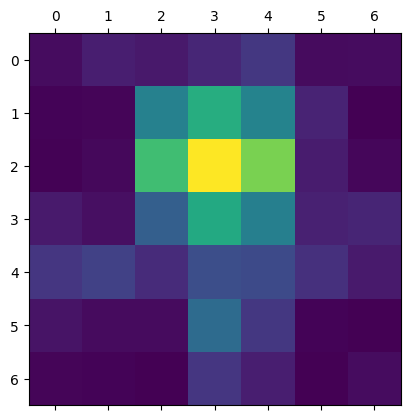

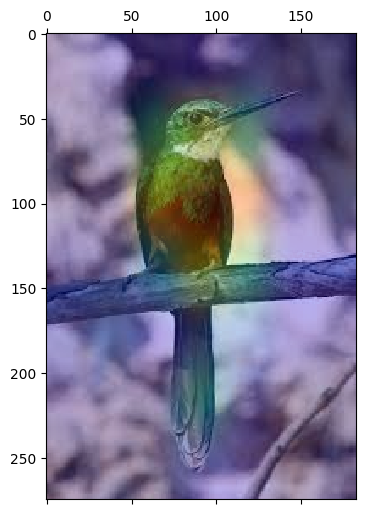

In [48]:
# GradientTape 함수를 이용한 그레이디언트 계산
with tf.GradientTape() as tape:
  output_1 = model_1(x)
  tape.watch(output_1)
  preds = model_2(output_1)
  class_id = tf.argmax(preds[0])
  output_2 = preds[:,class_id]

# 그레이디언트 계산
grads =  tape.gradient(output_2,output_1)
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2))

output_1 = output_1.numpy()[0]
pooled_grads = pooled_grads.numpy()

for i in range(pooled_grads.shape[-1]):
  output_1[:,:,i]*=pooled_grads[i]
heatmap = np.mean(output_1, axis= -1)

heatmap = np.maximum(heatmap,0) / np.max(heatmap)  # 0, 1로 정규화
plt.matshow(heatmap)

# 열 지도를 입력 영상에 덧씌움
img = image.load_img(image_path)

img = image.img_to_array(img)
heatmap = np.uint8(255*heatmap)  # [0,255] 변환

jet = cm.get_cmap('jet') # [0,255] 열 지도를 jet 컬러맵으로 변환
color = jet(np.arange(256))[:,:3]
color_heatmap = color[heatmap]

color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize((img.shape[1],img.shape[0]))
color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

overlay_img = color_heatmap*0.4+img # 덧씌움
overlay_img = keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)